# Hello World Example

This is a simple Jupyter Notebook that walks through the 4 steps of compiling and running a PyTorch model on the embedded Neural Processing Unit (NPU) in your AMD Ryzen AI enabled PC. The steps are as follows:

1. Get model - download or create a PyTorch model that we will run on the NPU
2. Export to ONNX - convert the PyTorch model to ONNX format.
3. Quantize - optimize the model for faster inference on the NPU by reducing its precision to INT8.
4. Run Model on CPU and NPU - compare performance between running the model on the CPU and on the NPU.

In [19]:
# Before starting, be sure you've installed the requirements listed in the requirements.txt file:
!python -m pip install -r requirements.txt

### 0. Imports & Environment Variables

We'll use the following imports in our example. `torch` and `torch_nn` are used for building and running ML models. We'll use them to define a small neural network and to generate the model weights. `os` is used for interacting with the operating system and is used to manage our environment variables, file paths, and directories. `subprocess` allows us to retrieve the hardware information. `onnx` and `onnxruntime` are used to work with our model in the ONNX format and for running our inference. `vai_q_onnx` is part of the Vitis AI Quantizer for ONNX models. We use it to perform quantization, converting the model into an INT8 format that is optimized for the NPU.

In [20]:
import torch
import torch.nn as nn
import os
import subprocess
import onnxruntime
import numpy as np
import onnx
import shutil
from timeit import default_timer as timer
import vai_q_onnx

As well, we want to set the environment variables based on the NPU device we have in our PC. For more information about NPU configurations, see: For more information about NPU configurations, refer to the official [AMD Ryzen AI Documentation](https://ryzenai.docs.amd.com/en/latest/runtime_setup.html).

In [21]:
# This function detects the APU (NPU) type in your system to configure environment variables for hardware-specific optimization.
def get_apu_info():
    # Run pnputil as a subprocess to enumerate PCI devices
    command = r'pnputil /enum-devices /bus PCI /deviceids '
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    # Check for supported Hardware IDs
    apu_type = ''
    if 'PCI\\VEN_1022&DEV_1502&REV_00' in stdout.decode(): apu_type = 'PHX/HPT'
    if 'PCI\\VEN_1022&DEV_17F0&REV_00' in stdout.decode(): apu_type = 'STX'
    if 'PCI\\VEN_1022&DEV_17F0&REV_10' in stdout.decode(): apu_type = 'STX'
    if 'PCI\\VEN_1022&DEV_17F0&REV_11' in stdout.decode(): apu_type = 'STX'
    return apu_type

apu_type = get_apu_info()
print(f"APU Type: {apu_type}")

APU Type: PHX/HPT


In [22]:
# XLNX_VART_FIRMWARE - Specifies the firmware file used by the NPU for runtime execution
# NUM_OF_DPU_RUNNERS - Specifies the number of DPU runners (processing cores) available for execution
# XLNX_TARGET_NAME - Name of the target hardware configuration

def set_environment_variable(apu_type):

    install_dir = os.environ['RYZEN_AI_INSTALLATION_PATH']
    match apu_type:
        case 'PHX/HPT':
            print("Setting environment for PHX/HPT")
            os.environ['XLNX_VART_FIRMWARE']= os.path.join(install_dir, 'voe-4.0-win_amd64', 'xclbins', 'phoenix', '1x4.xclbin')
            os.environ['NUM_OF_DPU_RUNNERS']='1'
            os.environ['XLNX_TARGET_NAME']='AMD_AIE2_Nx4_Overlay'
        case 'STX':
            print("Setting environment for STX")
            os.environ['XLNX_VART_FIRMWARE']= os.path.join(install_dir, 'voe-4.0-win_amd64', 'xclbins', 'strix', 'AMD_AIE2P_Nx4_Overlay.xclbin')
            os.environ['NUM_OF_DPU_RUNNERS']='1'
            os.environ['XLNX_TARGET_NAME']='AMD_AIE2_Nx4_Overlay'
        case _:
            print("Unrecognized APU type. Exiting.")
            exit()
    print('XLNX_VART_FIRMWARE=', os.environ['XLNX_VART_FIRMWARE'])
    print('NUM_OF_DPU_RUNNERS=', os.environ['NUM_OF_DPU_RUNNERS'])
    print('XLNX_TARGET_NAME=', os.environ['XLNX_TARGET_NAME'])

set_environment_variable(apu_type)

Setting environment for PHX/HPT
XLNX_VART_FIRMWARE= C:\Program Files\RyzenAI\1.4.1\voe-4.0-win_amd64\xclbins\phoenix\1x4.xclbin
NUM_OF_DPU_RUNNERS= 1
XLNX_TARGET_NAME= AMD_AIE2_Nx4_Overlay


### 1. Get Model
Here, we'll use the PyTorch library to define and instantiate a simple neural network model called `SmallModel` as a starting point. You can swap this model with any custom model, but make sure the input/output shapes remain compatible.

In [23]:
import os
import zipfile

extract_dir = "unzipped_files"  # or any directory you want to extract to
output = "unzipped_files/inputfiles.zip"

# Unzip the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: unzipped_files


In [24]:
import numpy as np
SPEED_OF_LIGHT = 299792458.0

def read_npy_data(path):
    baselines = np.load(f"{path}/baselines.npy")
    visibilities = np.load(f"{path}/vis.npy")[0]
    frequency = np.load(f"{path}/freq.npy")
    return (frequency, visibilities, baselines)
npix_l, npix_m = 100, 100
frequency, visibilities, baselines = read_npy_data(path=extract_dir)
visR, visI = np.real(visibilities), np.imag(visibilities)
u, v, w = [baselines[:, :, i] for i in range(3)]
l, m = np.meshgrid(np.linspace(-1, 1, npix_l), np.linspace(1, -1, npix_m))
with np.errstate(all='ignore'):
    n = np.sqrt(1 - l**2 - m**2) - 1
    nan_mask = np.isnan(n)
    n = np.nan_to_num(n) # or else it doesnt work
print("Visibilities")
print("visR:", visR.shape, "visI:",  visI.shape)
print("Baselines")
print("u:", u.shape, "v:", v.shape, "w:", w.shape)
print("Frequency")
print("freq:", frequency.shape, "=", frequency[0])
print("LMN")
print("l:", l.shape, "m:", m.shape, "n:", n.shape)

Visibilities
visR: (96, 96) visI: (96, 96)
Baselines
u: (96, 96) v: (96, 96) w: (96, 96)
Frequency
freq: (1,) = 58593750.0
LMN
l: (100, 100) m: (100, 100) n: (100, 100)


In [25]:
import numpy as np

SPEED_OF_LIGHT = 299792458.0


def sky_imager_simple_just_exp_correct_shape(
    baselines,
    freq,
    npix_l: int,
    npix_m: int,
):
    """
    :param visibilities: 2d rectangular array of visibilities
    :param baselines: 3d array with u, v, w per antenna baseline (N^2)
    :param freq: the frequency in hertz
    :param npix_l: number of pixels length
    :param npix_m: number of pixels height
    :return: 2d image from the imaging process
    """
    exp_matrix = np.zeros((npix_l*npix_m,1 , baselines.shape[0], baselines.shape[1]), dtype=np.complex64)
    img = np.zeros((npix_l, npix_m), dtype=np.complex128)
    l, m = np.meshgrid(np.linspace(-1, 1, npix_l), np.linspace(1, -1, npix_m))
    n = np.sqrt(1 - l**2 - m**2) - 1

    for l_ix in range(npix_l):
        for m_ix in range(npix_m):
            exp_matrix[l_ix * npix_m + m_ix, :, :, :] = np.exp(
                    -2j
                    * np.pi
                    * freq
                    * (
                        baselines[:, :, 0] * l[l_ix, m_ix]
                        + baselines[:, :, 1] * m[l_ix, m_ix]
                        + baselines[:, :, 2] * n[l_ix, m_ix]
                    )
                    / SPEED_OF_LIGHT

            )
            if l_ix == 4 and m_ix == 4:
              print("we multiply matrix visibilities at L_ix == 4 and m_ix index ",l_ix * npix_m + m_ix ,"with exp matrix: ", exp_matrix[l_ix * npix_m + m_ix, :, :, :]  )


    return exp_matrix

In [26]:
import torch
import torch.nn as nn

class ElementwiseMult_Astron_final(nn.Module):
  def __init__(self, matrix) -> None:
      super(ElementwiseMult_Astron_final, self).__init__()
      shape = matrix.shape

      self.batch, self.channels, self.height, self.width = shape
      #print("shape of exponential matrix: ", shape)

      self.conv_layer = nn.Conv2d(2, self.batch, bias=False, kernel_size= (self.width,self.height), stride= (1, 1), groups= 1)
      print("shape of kernel:", self.conv_layer.weight.data.shape)
      #weightsconv = matrix.view(self.batch*self.channels, 1, self.height,  self.width)
      weightsconv = matrix
      print("shape of our exponential kernel:", weightsconv.shape)

      self.conv_layer.weight.data = weightsconv

  def forward(self, x):
    shape = x.shape
    print("shape of input ElementwiseMult_Astron: ", shape)
    #batch_size = shape[0]


    #input = x.view(batch_size, self.height*self.width, 1, 1)
    print("TINA we multiply the visibilites:", x, "with the following index 4, 4", self.conv_layer.weight.data[4 * 10 + 4][0][:][:])
    out = self.conv_layer(x)
    print("shape of output: ", out.shape)
    #out = out.view(self.height, self.width)
    #print("shape of output after reshape: ", out.shape)
    out = out.view(1, 1, self.batch, 1)
    print("shape of output after reshape: ", out.shape)
    # out = out/9216.0
    #print("shape of output after division: ", out.shape)

    return out

In [27]:
from math import exp
class sky_imager_TINA_comp_final(nn.Module):
  def __init__(self,
    baselines,
    freq,
    npix_l: int,
    npix_m: int,) -> None:
      super(sky_imager_TINA_comp_final, self).__init__()
      # self.N = N      #exp_matrix = np.real(generate_exponential_matrix(baselines, freq, npix_l, npix_m))
      #exp_matrix = torch.from_numpy(exp_matrix).float()
      exp_matrix_imag = np.imag(sky_imager_simple_just_exp_correct_shape(baselines, freq, npix_l, npix_m))
      print("numpy version exp mat: ", exp_matrix_imag[4 * 10 + 4][0][:][:])
      exp_matriximag_tensor = torch.from_numpy(exp_matrix_imag).float()
      exp_matriximag_tensor = exp_matriximag_tensor * -1
      print("numpy version exp mat: ", exp_matriximag_tensor[4 * 10 + 4][0][:][:])
      shapexp = exp_matriximag_tensor.shape

      print("before reshape", shapexp)

      #exp_matrix = exp_matrix.view(shapexp[3],  shapexp[2], shapexp[1], shapexp[0] )
      #print("after reshape", exp_matrix.shape)
      #self.matrix_mult_imag = ElementwiseMult_Astron_alt_comp(exp_matriximag_tensor)

      exp_matrix_real = np.real(sky_imager_simple_just_exp_correct_shape(baselines, freq, npix_l, npix_m))
      print("numpy version exp mat: ", exp_matrix_real[4 * 10 + 4][0][:][:])
      exp_matrixreal_tensor = torch.from_numpy(exp_matrix_real).float()
      print("numpy version exp mat: ", exp_matrix_real[4 * 10 + 4][0][:][:])
      shapexp = exp_matrixreal_tensor.shape
      #self.summation = Summation(self.N)
      #self.matrix_mult_real = ElementwiseMult_Astron_alt(exp_matrixreal_tensor)
      exp_matrix_comp = torch.concat((exp_matrixreal_tensor, exp_matriximag_tensor), dim=1)
      print("after stack", exp_matrix_comp.shape)
      self.matrix_mult = ElementwiseMult_Astron_final(exp_matrix_comp)


  def forward(self, x):
    print("shape of input Sky_imager_TINA_real: ", x.shape)
    outputcomp = self.matrix_mult(x)


    #output =  outputcomp[:,:,:npix_l*npix_m,:] - outputcomp[:,:,npix_l*npix_m:,:]
    #x = x
    #x = x * self.exp_matrix
    #print(x.shape)
    #x = self.summation(x)
    #x = x/self.N


    return outputcomp

In [28]:
# vis_tensor_imag = torch.from_numpy(np.imag(visibilities)).float()
# vis_tensor_real = torch.from_numpy(np.real(visibilities)).float()
# shape_input = vis_tensor_real.shape

# vis_tensor_imag = vis_tensor_imag.view(1, 1, shape_input[0],  shape_input[1])
# vis_tensor_real = vis_tensor_real.view(1, 1, shape_input[0],  shape_input[1])
# vis_tensor_comp = torch.concat((vis_tensor_real, vis_tensor_imag), dim=1)
# print("after stack input", vis_tensor_comp.shape)

# Instantiate the model
pytorch_model = sky_imager_TINA_comp_final(baselines, frequency, npix_l, npix_m)

pytorch_model.eval()

# Print the model architecture
print(pytorch_model)

C:\Users\mruiz\AppData\Local\Temp\ipykernel_11424\1869593315.py:23: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(1 - l**2 - m**2) - 1


we multiply matrix visibilities at L_ix == 4 and m_ix index  404 with exp matrix:  [[[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
  [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
  [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
  ...
  [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
  [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]
  [nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]]]
numpy version exp mat:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
numpy version exp mat:  tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
before 

### 2. Export to ONNX

The following code is used for exporting a PyTorch model (pytorch_model) to the ONNX (Open Neural Network Exchange) format. ONNX is an open format that facilitates interoperability between different AI frameworks. Ryzen AI uses ONNX as the input format for quantization using the Vitis AI Quantizer. 

In [29]:
# Generate dummy input data
# batch_size = 1
# input_channels = 3
# input_size = 224
# dummy_input = torch.rand(batch_size, input_channels, input_size, input_size)

# Prep for ONNX export
# inputs = {"x": dummy_input}
# dynamic_axes = {'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# tmp_model_path = "models/helloworld.onnx"
input1 = torch.randn(1, 2, 96, 96)
inputs = {"x": input1}
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

model_path = "models/lofty.onnx"

# Call export function
torch.onnx.export(
        pytorch_model,
        inputs,
        model_path,
        export_params=True,
        opset_version=17,  # Recommended opset
        input_names=['input'],
        output_names=['output'],
        dynamic_axes=dynamic_axes,
    )

shape of input Sky_imager_TINA_real:  torch.Size([1, 2, 96, 96])
shape of input ElementwiseMult_Astron:  torch.Size([1, 2, 96, 96])
TINA we multiply the visibilites: tensor([[[[ 0.3370,  1.7677,  1.6209,  ..., -0.3774,  0.8990,  0.0420],
          [ 0.1313,  0.1344,  1.4482,  ...,  0.1656,  0.7335,  0.8305],
          [ 1.7172,  0.4603, -0.1949,  ..., -1.6016,  0.2487, -0.5024],
          ...,
          [ 1.6895, -1.2703, -0.5163,  ...,  0.3649,  0.2814,  0.6664],
          [-0.1534, -1.9907, -0.1386,  ...,  1.6247,  0.1335,  0.8271],
          [ 0.2850, -0.6006, -0.7065,  ..., -0.7007,  0.0060,  0.8930]],

         [[ 0.0434, -0.4165,  0.0881,  ..., -0.8262, -0.9664,  0.5763],
          [ 0.9179, -0.1548, -0.6990,  ...,  0.8191,  0.0580, -0.2415],
          [ 0.1223, -0.0255, -0.7634,  ..., -0.9970,  0.7605,  0.1359],
          ...,
          [ 0.0774, -0.6376, -0.4127,  ...,  1.2355, -0.7214,  1.2455],
          [ 0.4281,  1.3203,  1.3006,  ...,  0.3964,  0.6433,  0.1547],
          

### 3. Quantize Model

Using the static quantization method provided by the AMD Quark Quantizer and providing the newly exported ONNX model, we'll quantize the model to INT8. Quantization reduces the precision of model weights and activations from 32-bit floating point (FP32) to 8-bit integers (INT8). This compression allows the model to run faster on hardware accelerators like NPUs, while maintaining nearly the same accuracy. For more information on this quantization method, see [AMD Quark Quantization](https://ryzenai.docs.amd.com/en/latest/modelport.html).

In [30]:
# from quark.onnx.quantization.config import Config, get_default_config
# from quark.onnx import ModelQuantizer

# # `input_model_path` is the path to the original, unquantized ONNX model.
# input_model_path = "models/helloworld.onnx"

# # `output_model_path` is the path where the quantized model will be saved.
# output_model_path = "models/helloworld_quantized.onnx"

# # Use default quantization configuration
# quant_config = get_default_config("XINT8")
# quant_config.extra_options["UseRandomData"] = True
# # Defines the quantization configuration for the whole model
# config = Config(global_quant_config=quant_config)
# print("The configuration of the quantization is {}".format(config))

# # Create an ONNX Quantizer
# quantizer = ModelQuantizer(config)

# # Quantize the ONNX model
# quant_model = quantizer.quantize_model(model_input = input_model_path,
#                                        model_output = output_model_path,
#                                        calibration_data_path = None)

# print('Calibrated and quantized model saved at:', output_model_path)

### 4. Run Model

#### CPU Run

Before runnning the model on the NPU, we'll run the model on the CPU and get the execution time for comparison with the NPU.

In [47]:
# Specify the path to the quantized ONNZ Model
quantized_model_path = r'./models/lofty.onnx'
model = onnx.load(quantized_model_path)

# Create some random input data for testing
# input_data = np.random.uniform(low=-1, high=1, size=(batch_size, input_channels, input_size, input_size)).astype(np.float32)
vis_tensor_imag = torch.from_numpy(np.imag(visibilities)).float()
vis_tensor_real = torch.from_numpy(np.real(visibilities)).float()
shape_input = vis_tensor_real.shape

vis_tensor_imag = vis_tensor_imag.view(1, 1, shape_input[0],  shape_input[1])
vis_tensor_real = vis_tensor_real.view(1, 1, shape_input[0],  shape_input[1])
vis_tensor_comp = torch.concat((vis_tensor_real, vis_tensor_imag), dim=1)
print(vis_tensor_comp.shape)
input_data = {"input": vis_tensor_comp.numpy()}

cpu_options = onnxruntime.SessionOptions()

# Create Inference Session to run the quantized model on the CPU
cpu_session = onnxruntime.InferenceSession(
    model.SerializeToString(),
    providers = ['CPUExecutionProvider'],
    sess_options=cpu_options,
)

for input_info in cpu_session.get_inputs():
    print(f"Input name: {input_info.name}, shape: {input_info.shape}")

# Run Inference
start = timer()
cpu_results = cpu_session.run(None, input_data)
cpu_total = timer() - start
print(cpu_total)

torch.Size([1, 2, 96, 96])
Input name: input, shape: ['batch_size', 2, 96, 96]
0.06281259993556887


#### NPU Run

Now, we'll run it on the NPU and time the execution so that we can compare the results with the CPU.
If the model has already been compiled, it won't recompile unless you delete the generated cache folder using the following cell.

In [32]:
# We want to make sure we compile everytime, otherwise the tools will use the cached version
# Get the current working directory
current_directory = os.getcwd()
directory_path = os.path.join(current_directory,  r'cache\tina_cache')
cache_directory = os.path.join(current_directory,  r'cache')

# Check if the directory exists and delete it if it does.
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Directory deleted successfully. Starting Fresh.")
else:
    print(f"Directory '{directory_path}' does not exist.")

Directory deleted successfully. Starting Fresh.


#### Compile and run

On the first run, the model will compile for the NPU before executing the inference. It's best to run the following cell again if you want to see better inference times.

In [33]:
install_dir = os.environ['RYZEN_AI_INSTALLATION_PATH']
config_file_path = os.path.join(install_dir, 'voe-4.0-win_amd64', 'vaip_config.json') # Path to the NPU config file

aie_options = onnxruntime.SessionOptions()

aie_session = onnxruntime.InferenceSession(
    model.SerializeToString(),
    providers=['VitisAIExecutionProvider'],
    sess_options=aie_options,
    provider_options = [{'config_file': config_file_path,
                         'cacheDir': cache_directory,
                         'cacheKey': 'tina_cache'}]
)



In [50]:
# Run Inference
for _ in range(20):
    start = timer()
    npu_results = aie_session.run(None, input_data)
    npu_total = timer() - start

Let's gather our results and see what we have

In [51]:
print(f"CPU Execution Time: {cpu_total}")
print(f"NPU Execution Time: {npu_total}")

CPU Execution Time: 0.06281259993556887
NPU Execution Time: 0.02830040000844747


output shape: (100, 100)


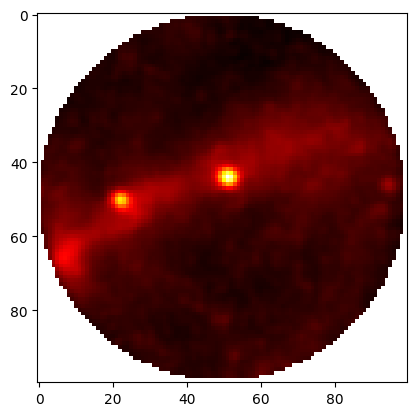

In [52]:
from matplotlib import pyplot as plt

output = np.array(npu_results).reshape(npix_l, npix_m)
print("output shape:", output.shape)
# output = output.reshape(npix_l, npix_m).detach().numpy()
plt.imshow(output, cmap='hot', interpolation='nearest')
plt.show()

**Note:** For a model this small in size, you likely won't see much of a performance gain when using the NPU versus the CPU. 

Let's take a look at running the model on the NPU lots of times so that we can see the NPU being utilized.
To do this, make sure to have Task Manager opened in a window you can see when you run the next cell.

In [ ]:
iterations = 50 # edit this for more or less

for i in range(iterations):
    npu_results = aie_session.run(None, {'input': input_data})



And there you have it. Your first model running on the NPU. We recommend trying a more complex model like ResNet50 or a custom model to compare performance and accuracy on the NPU.
